# CGM preediction tests #
## Michael Strand / Chelsea Huynh ##


In [205]:
import pandas as pd
import numpy as np
import matplotlib as plt

# breathing table

raw_breathing = pd.read_csv('2014_10_02-10_56_44_Breathing.csv')
raw_breathing['Time'] = raw_breathing['Time'].str[10:]
raw_breathing_slim = raw_breathing.loc[(raw_breathing['Time']).str[-3:] == '420']
raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]

# ecg table

raw_ecg = pd.read_csv('2014_10_02-10_56_44_ECG.csv')
raw_ecg['Time'] = raw_ecg['Time'].str[10:]
raw_ecg_slim = raw_ecg.loc[(raw_ecg['Time']).str[-3:] == '424']
raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]

# trim glucose measures so we can properly shape our A matrix 

raw_glucose = pd.read_csv('P1_glucose.csv')
raw_glucose_day1 = raw_glucose.loc[(raw_glucose['date']).str[-1] == '2']
raw_glucose_day1 = raw_glucose_day1.drop('comments', axis=1)

# start at 10:56
raw_glucose_day1_trim = raw_glucose_day1.iloc[135:-30]
raw_glucose_day1_trim['time'] = raw_glucose_day1_trim['time'].str[:5]

# drop manual imputations for conistancy 
raw_glucose_day1_trim = raw_glucose_day1_trim.loc[(raw_glucose_day1_trim['type']) == 'cgm']

C:\Users\mikew\AppData\Local\Temp/ipykernel_9108/784069599.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_9108/784069599.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_9108/784069599.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [206]:
raw_summary = pd.read_csv('2014_10_02-10_56_44_Summary.csv')
raw_summary = raw_summary.iloc[436:-424] # trim measurements that don't correspond to a prediction (5 minute interval)
raw_summary['Time'] = raw_summary['Time'].str[10:]
raw_summary['Time'] = raw_summary['Time'].str[:9]

noise = raw_summary[['ECGNoise']]

# junk variables (all constant)
raw_summary = raw_summary.drop('BRNoise', axis=1)
raw_summary = raw_summary.drop('BRConfidence', axis=1)
raw_summary = raw_summary.drop('GSR', axis=1)
raw_summary = raw_summary.drop('LinkQuality', axis=1)
raw_summary = raw_summary.drop('RSSI', axis=1)
raw_summary = raw_summary.drop('TxPower', axis=1)
raw_summary = raw_summary.drop('ECGNoise', axis=1)

# HR != 0 in a living human
raw_summary['HR'] = raw_summary['HR'].mask(raw_summary['HR'] == 0).ffill()


# take eta readings per minute rather than 60 (otherwise we have too many variables n > m)

eta = 3 # how many times per minute do we take a reading
raw_summary = raw_summary.iloc[::60//eta, :]

In [207]:
raw_summary

,Time,HR,BR,SkinTemp,Posture,Activity,PeakAccel,BatteryVolts,BatteryLevel,BRAmplitude,...,LateralMin,LateralPeak,SagittalMin,SagittalPeak,DeviceTemp,StatusInfo,CoreTemp,AuxADC1,AuxADC2,AuxADC3
436,11:04:00,116.0,12.2,-3276.8,-9,0.06,0.12,4.152,92,23.0,...,-0.20,-0.10,0.03,0.16,27.7,531,36.9,416,422,483
456,11:04:20,140.0,13.7,-3276.8,12,0.37,0.80,4.151,91,26.0,...,-0.48,0.07,-0.24,0.38,27.9,512,36.9,407,408,478
476,11:04:40,163.0,10.7,-3276.8,-17,0.31,0.38,4.151,91,38.0,...,-0.19,-0.07,-0.15,0.22,27.9,528,37.1,415,423,484
496,11:05:00,175.0,7.1,-3276.8,-11,0.02,0.04,4.151,91,10.0,...,-0.19,-0.12,0.09,0.20,28.1,531,37.1,413,420,483
516,11:05:20,173.0,12.4,-3276.8,-10,0.04,0.10,4.151,91,25.0,...,-0.18,-0.06,0.08,0.22,28.2,531,37.1,414,421,483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38136,21:32:20,36.0,10.2,-3276.8,-6,0.60,1.07,3.808,34,165.0,...,-0.63,0.28,-0.57,0.48,33.3,528,35.6,421,422,495
38156,21:32:40,35.0,8.5,-3276.8,21,0.03,0.10,3.808,34,99.0,...,-0.45,-0.36,-0.06,0.01,33.2,528,35.5,414,420,483
38176,21:33:00,35.0,8.0,-3276.8,-10,0.20,0.57,3.808,34,78.0,...,-0.74,-0.08,-0.24,0.20,33.2,531,35.5,415,421,483
38196,21:33:20,124.0,5.3,-3276.8,3,0.32,0.38,3.807,34,199.0,...,0.13,0.21,0.03,0.16,33.2,528,35.5,415,420,482


In [208]:
from sklearn.preprocessing import StandardScaler

# normalize
qualities_copy = qualities.copy()

qualities_copy = pd.concat([raw_summary.set_index('Time'), 
                       raw_breathing_slim.set_index('Time'), 
                       raw_ecg_slim.set_index('Time')],
                axis=1, join='inner')

scaler = StandardScaler(copy = True)

qualities_norm = qualities_copy.copy()

qualities_norm = qualities_norm[['HR', 'ECGAmplitude', 'EcgWaveform']]
qualities_copy = qualities_copy[['HR', 'ECGAmplitude', 'EcgWaveform']]

qualities_norm = scaler.fit_transform(qualities_norm)

Let each row of the new matrix A represent 5 minutes of observations. That is, each of the 3 experimental variables will appear 300 times and in tuples of (Hr, ECGAmplitude, EcgWaveform); grouped by exact seconds. These 3-tuples will be considered 'missing' if the average for the ECGNoise is large (i.e., > 0.005).

In [209]:
noise_copy = noise.copy()
qualities_copy = qualities.copy()
qualities_norm_copy = qualities_norm.copy()

# reshape data into A
feature_count = len(qualities.columns)

m = len(raw_glucose_day1_trim)
n = 5*eta*feature_count # where 5 is due to glucose measures being taken every 5 minutes

A = np.reshape(qualities_copy.to_numpy(), (m,n))
A_norm = np.reshape(qualities_norm_copy, (m,n))

Below: each row represents 5 minutes worth of 1 second (HR, ECGamp, ECGwave) tuples) taken every 20 seconds

In [210]:
df_A = pd.DataFrame(A)
df_A_norm = pd.DataFrame(A_norm)

In [133]:
noise.describe()

,ECGNoise
count,37800.000000
mean,0.000348
std,0.000494
min,0.000020
25%,0.000080
50%,0.000160
75%,0.000400
max,0.009080


In [227]:
mask = np.ones((m,n))

noise_vec = noise_copy.to_numpy()
df_A_norm_copy = df_A_norm.copy().to_numpy()
df_A_copy = df_A.copy().to_numpy()

too_high_noise = 0.009

index = 0
zeros = 0

for i in range(m):
    for j in range(n//feature_count):
        
        if noise_vec[index] > too_high_noise:
            
            zeros += 3
            df_A_norm_copy[i, 3*j:3*(j+1)] = 0
            df_A_copy[i, 3*j:3*(j+1)] = 0
        index += 1

<AxesSubplot:>

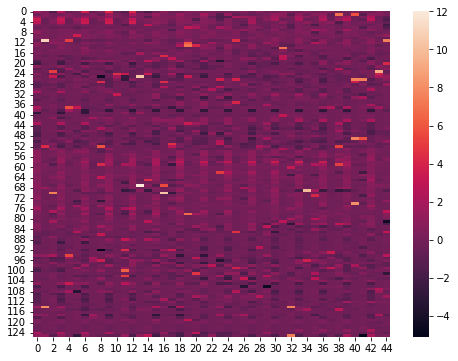

In [228]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_A_norm_copy, annot=False)

In [229]:
display(df_A_norm)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.786454,0.404622,-1.501915,2.804451,-0.608428,-0.033931,3.780031,-0.608428,0.361930,4.289029,...,0.011428,0.174626,0.624850,-0.178255,-0.079873,0.478031,0.135135,-0.334372,0.566123,-0.116402
1,-0.164706,0.580805,-0.083414,0.004960,0.610168,-0.046302,0.174626,0.566123,-0.586487,1.616788,...,0.704185,1.235039,-0.711202,6.947240,0.004960,5.836921,-1.089560,1.065373,0.654214,0.122764
2,1.404705,0.433986,-0.038054,1.574371,0.551441,0.262965,1.192623,0.448668,0.510378,1.150206,...,0.027922,1.744037,-0.402882,0.832015,1.828871,-0.402882,0.341312,2.168203,-0.432246,-1.015336
3,3.440699,-0.432246,0.378424,3.313449,-0.432246,1.256740,3.228616,-0.432246,0.596972,3.313449,...,0.023799,2.422702,-0.373518,1.372200,2.549951,-0.373518,-0.759676,2.846867,-0.373518,-1.712216
4,2.762034,-0.432246,0.465019,2.931700,-0.432246,0.667073,3.355866,-0.432246,-0.153514,3.567948,...,-0.050425,0.471542,0.845079,-1.600880,0.429125,-0.182654,0.093899,0.429125,-0.182654,-0.759676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.376789,-0.182654,-0.017437,-0.376789,-0.182654,-0.066919,-0.376789,-0.182654,-0.071043,-0.376789,...,-0.091661,-0.376789,-0.182654,-0.062796,-0.376789,-0.182654,-0.075166,-0.376789,-0.182654,-0.066919
122,-0.376789,-0.182654,-0.054549,-0.376789,-0.182654,-0.009190,-0.376789,-0.182654,-0.050425,-0.376789,...,0.073281,-0.376789,-0.182654,0.073281,-0.376789,-0.182654,0.221729,-0.291956,-0.417564,-0.372062
123,-0.376789,-0.182654,-0.170008,-0.376789,-0.182654,-0.091661,-0.376789,-0.182654,-0.165885,-0.376789,...,-0.025684,0.895707,-0.182654,-0.071043,0.895707,-0.182654,-0.054549,2.083370,-0.167972,-0.128773
124,2.040953,-0.182654,-0.054549,2.040953,-0.182654,0.019675,2.040953,-0.182654,-0.058672,2.040953,...,0.386671,-0.291956,-0.461610,-0.141143,-0.291956,-0.182654,-0.565869,0.259459,-0.182654,-0.685452


In [231]:
import random

# ell-tuples stochastic gradient descent algorithm 

# Parameters
    # n: number of columns
    # x: value to approximate (true soln of Ax = y)
    # maxiter: Iteration count stopping condition (this is our m, row count)
    # p: probability that Q-tuple will be blocked out
    # ell: size of missing tuples
    # alpha: Iteration step size

def ltuple_msgd(A_tilde, y, maxiter, p, ell, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))
    
    # Create Matrix Q for the update function
    L_matrix = np.zeros((n,n))
    for i in range(0, n - (n % ell), ell):
        v = np.zeros((n))
        v[i:i + ell] = 1
        L_matrix = L_matrix + (np.outer(v,v))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        
        Ai_tilde = A_tilde[i,:]
        
        At = np.transpose(Ai_tilde)
        A1 = Ai_tilde*xhat - p*y[i]
        AA = np.dot(At, A1).reshape((n,1))
        BB = np.multiply(L_matrix, np.outer(Ai_tilde, Ai_tilde))
        CC = np.dot(BB, xhat)
        
        gxk = (1/p**2)*AA - ((1-p)/p**2)*CC
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        current_iter += 1
            
    return resid_err

1.0


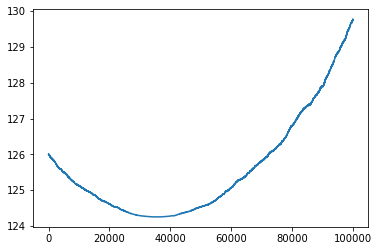

In [232]:
A_tilde = df_A_norm.to_numpy()

y_glucose = pd.DataFrame(raw_glucose_day1_trim['glucose']).to_numpy().reshape(-1,1)

scaler2 = StandardScaler(copy = True)
y_glucose_norm = scaler2.fit_transform(y_glucose)

maxiter = 100000
p = 1 - zeros/(m*n) # estimate for probability data present
ell = feature_count
alpha = 2*10**(-7)
print(p)
lerr = ltuple_msgd(A_tilde, y_glucose_norm, maxiter, p, ell, alpha)

plt.plot(lerr)